In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import emukit
import GPy
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper

from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from emukit.core.acquisition import IntegratedHyperParameterAcquisition



In [2]:
# 读取CSV文件中的数据
file_path = 'data/aryl-1.csv'
data = pd.read_csv(file_path, encoding='utf-8', header=None)

# 删除第20列到第46列   #去除芳香卤卤化物的描述符
columns_to_drop = data.columns[19:45]  
data = data.drop(columns=columns_to_drop, axis=1)

# 将最后一列作为y，其他列作为x
y_exp = -data.iloc[:, -1].values  # 最后一列 加 负号
x_exp = data.iloc[:, :-1].values  # 前面所有列

X_all, Y_all = [x_exp, y_exp]

Y_all = Y_all.reshape(-1, 1)

X = X_all
Y = Y_all

num_samples_X = X.shape[0]  # X中的样本点个数
num_samples_Y = Y.shape[0]  # Y中的样本点个数

print(f"X中的原始样本点个数：{num_samples_X}")
print(f"Y中的原始样本点个数：{num_samples_Y}")


#去除存在nan的点
nan_indices = np.isnan(Y)
X = X[~nan_indices.flatten()]
Y = Y[~nan_indices.flatten()]

nan_count = np.sum(nan_indices)
print(f"包含NaN的点的个数：{nan_count}")


X中的原始样本点个数：264
Y中的原始样本点个数：264
包含NaN的点的个数：0


In [3]:
num_samples_X = X.shape[0]  # X中的样本点个数
num_samples_Y = Y.shape[0]  # Y中的样本点个数

print(f"X中的最终样本点个数：{num_samples_X}")
print(f"Y中的最终样本点个数：{num_samples_Y}")


X中的最终样本点个数：264
Y中的最终样本点个数：264


# 二八划分训练测试

In [4]:
from sklearn.model_selection import train_test_split

# 将X和Y按照8:2的比例划分为训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [5]:
print(X.shape)
print(Y.shape)

(264, 94)
(264, 1)


In [6]:
# 建立模型
input_dim = 94

ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#

ker.lengthscale.constrain_bounded(0.01, 10) #lengthscale决定着点与点之间的相互作用程度
ker.variance.constrain_bounded(1e-2, 1e4) #方差

model_gpy = GPRegression(X_train,Y_train, ker)

model_gpy.Gaussian_noise.variance = 1.5**2
model_gpy.Gaussian_noise.variance.fix()

model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts=10,verbose =False, messages=False)

base_model_1 = GPyModelWrapper(model_gpy)
# print(base_model_1.model.lengthscale)
print(base_model_1.model.kern.lengthscale)
print(base_model_1.model.kern.variance)



ei_acquisition = NegativeLowerConfidenceBound(base_model_1)

ei_plot = ei_acquisition.evaluate(X_all)
nlcb_1 = (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot))






reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


  index  |  GP_regression.Mat52.lengthscale  |  constraints  |  priors
  [0]    |                       1.94772352  |   0.01,10.0   |        
  [1]    |                       2.41590067  |   0.01,10.0   |        
  [2]    |                       1.47034671  |   0.01,10.0   |        
  [3]    |                       1.31609580  |   0.01,10.0   |        
  [4]    |                      10.00000000  |   0.01,10.0   |        
  [5]    |                      10.00000000  |   0.01,10.0   |        
  [6]    |                      10.00000000  |   0.01,10.0   |        
  [7]    |                      10.00000000  |   0.01,10.0   |        
  [8]    |                      10.00000000  |   0.01,10.0   |        
  [9]    |                       2.40217368  |   0.01,10.0   |        
  [10]   |                      10.00000000  |   0.01,10.0   |        
  [11]   |                      10.00000000  |   0.01,10.0   |        
  [12]   |                      10.00000000  |   0.01,10.0   |        
  [13]

Train Set Metrics:
MAE: 0.31   RMSE: 0.4   spearman: 0.998   R² score: 0.998
Test Set Metrics:
MAE: 3.67   RMSE: 5.29   spearman: 0.879   R² score: 0.705


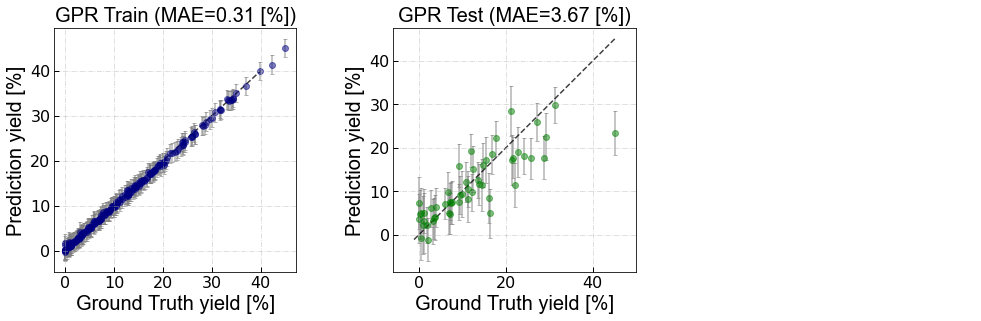

In [7]:
f_obj =  base_model_1.model.predict
y_pred, y_uncer = f_obj(X_train)
y_pred = -y_pred[:,-1]
y_uncer = np.sqrt(y_uncer[:,-1])
y_truth = -Y_train[:,-1]

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr
fig, axes = plt.subplots(1, 3, figsize=(5.5*3, 4.5))
fs = 20
lims1 = (0, 40)
axes[0].scatter(y_truth, y_pred, alpha = 0.5, c = 'navy' , edgecolor = 'navy')
axes[0].errorbar(y_truth, y_pred, yerr = y_uncer, ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
axes[0].plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)

rmse_value = np.sqrt(mean_squared_error(y_truth, y_pred))
mae_value = mean_absolute_error(y_truth, y_pred)
spearman_value = spearmanr(y_truth, y_pred)[0]
rsquared_value = r2_score(y_truth, y_pred)

print('Train Set Metrics:')
print('MAE:',np.round(mae_value,2), ' ',
      'RMSE:', np.round(rmse_value,2), ' ',
      'spearman:', np.round(spearman_value,3), ' ',
      'R² score:', np.round(rsquared_value,3))

title = 'GPR Train' + " (MAE=%.2f" % mae_value+' [%])'
axes[0].set_xlabel('Ground Truth yield [%]', fontproperties='Arial',fontsize = fs)
axes[0].set_ylabel('Prediction yield [%]',fontproperties='Arial', fontsize = fs)
axes[0].set_title(title, fontsize = fs,fontproperties='Arial')
        
for i in range(len(axes)):
    axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
    axes[i].grid(True, linestyle='-.')
plt.subplots_adjust(wspace = 0.4)




# 使用测试集 X_test 进行预测
y_pred_test, y_uncer_test = f_obj(X_test)
y_pred_test = -y_pred_test[:,-1]
y_uncer_test = np.sqrt(y_uncer_test[:,-1])
y_truth_test = -Y_test[:,-1]

# 计算两个子图共享的坐标范围
min_value = min(np.min(y_truth), np.min(y_pred), np.min(y_truth_test), np.min(y_pred_test))
max_value = max(np.max(y_truth), np.max(y_pred), np.max(y_truth_test), np.max(y_pred_test))

# 计算测试集上的性能指标
rmse_value_test = np.sqrt(mean_squared_error(y_truth_test, y_pred_test))
mae_value_test = mean_absolute_error(y_truth_test, y_pred_test)
spearman_value_test = spearmanr(y_truth_test, y_pred_test)[0]
rsquared_value_test = r2_score(y_truth_test, y_pred_test)

# 创建第二个子图，绘制测试集性能
axes[1].scatter(y_truth_test, y_pred_test, alpha=0.5, c='green', edgecolor='green')
axes[1].errorbar(y_truth_test, y_pred_test, yerr=y_uncer_test, ms=0, 
                 ls='', capsize=2, alpha=0.6,
                 color='gray', zorder=0)

axes[1].plot([min_value, max_value], [min_value, max_value], 'k--', alpha=0.75, zorder=0)

title_test = 'GPR Test' + " (MAE=%.2f" % mae_value_test+' [%])'
axes[1].set_xlabel('Ground Truth yield [%]', fontproperties='Arial', fontsize=fs)
axes[1].set_ylabel('Prediction yield [%]', fontproperties='Arial', fontsize=fs)
axes[1].set_title(title_test, fontsize=fs, fontproperties='Arial')

axes[1].axis('equal')
# 打印测试集性能指标
print('Test Set Metrics:')
print('MAE:', np.round(mae_value_test, 2), ' ',
      'RMSE:', np.round(rmse_value_test, 2), ' ',
      'spearman:', np.round(spearman_value_test, 3), ' ',
      'R² score:', np.round(rsquared_value_test, 3))




axes[2].axis("off")

plt.show()


# 导入源模型帮助预测

In [8]:
#导入单个源模型

import os
import pickle

# 定义文件夹路径
folder_path = 'base-models'

num = 2


# 加载 base_model
file_path = os.path.join(folder_path, f'base_model_{num}.pkl')
with open(file_path, 'rb') as f:
    base_model = pickle.load(f)

    
base_models = []
base_models.append(base_model)
    
#必须要放在导入库的前面，否则内核挂掉，不知道为什么

In [19]:
# rgpe（taf）的一些参数
from rgpe import compute_model_weights
import copy

n_samples = 1000    #模型抽样个数

rng = np.random.RandomState(4)  #生成随机数种子
sampling_mode = 'bootstrap'

target_model = copy.deepcopy(base_model_1)

train_x = X_train
train_y = Y_train
num_samples = n_samples


def roll_col(X: np.ndarray, shift: int) -> np.ndarray:
    """
    Rotate columns to right by shift.
    """
    return np.concatenate((X[:, -shift:], X[:, :-shift]), axis=1)


predictions = []
for model_idx in range(len(base_models)):
    model = base_models[model_idx]
    predictions.append(model.predict(train_x)[0].flatten())   #每个base模型都给出预测

masks = np.eye(len(train_x), dtype=np.bool)
train_x_cv = np.stack([train_x[~m] for m in masks])
train_y_cv = np.stack([train_y[~m] for m in masks])
test_x_cv = np.stack([train_x[m] for m in masks]) # target模型 其他点做训练，其中一个点做预测

loo_prediction = []
for i in range(train_y.shape[0]):
    loo_model = target_model
    loo_model.set_data(train_x_cv[i], train_y_cv[i])
    loo_prediction.append(loo_model.predict(test_x_cv[i])[0][0][0])  
predictions.append(loo_prediction)
predictions = np.array(predictions) # base 和 target 的总预测，预测出来是应该是 mu

In [21]:
bootstrap_indices = rng.choice(predictions.shape[1],
                               size=(num_samples, predictions.shape[1]),
                               replace=True)  # 对predictions.shape[1]的维度个数进行抽样，比如predictions.shape[1] = 10 ，则从0-9抽数，所以出来是索引
bootstrap_predictions = []
bootstrap_targets = train_y[bootstrap_indices].reshape((num_samples, len(train_y))) # 抽样对应的y值
for m in range(len(base_models) + 1):
    bootstrap_predictions.append(predictions[m, bootstrap_indices])

ranking_losses = np.zeros((len(base_models) + 1, num_samples))
for i in range(len(base_models)):

    for j in range(len(train_y)):

        ranking_losses[i] += np.sum(
            (
                roll_col(bootstrap_predictions[i], j) < bootstrap_predictions[i])
                ^ (roll_col(bootstrap_targets, j) < bootstrap_targets
            ), axis=1
        )
for j in range(len(train_y)):
    ranking_losses[-1] += np.sum(
        (
            (roll_col(bootstrap_predictions[-1], j) < bootstrap_targets)   #这里为什么不是 bootstrap_predictions[-1] ？
            ^ (roll_col(bootstrap_targets, j) < bootstrap_targets)
        ), axis=1
    )

# ranking loss 计算结束

ranking_loss = np.array(ranking_losses)

In [33]:
ranking_loss_sums = ranking_loss.sum(axis=1, keepdims=True)
loss_sums = ranking_loss_sums.sum(axis=0, keepdims=True)
rank_weights = ranking_loss_sums/loss_sums
weight_list = rank_weights

w_s =  weight_list[:-1]
w_t = weight_list[-1]

In [40]:
def prediction_vs_ground_truth_fig(y_train, y_train_hat, y_test, y_test_hat):
    
    rmse_value = np.sqrt(mean_squared_error(y_train, y_train_hat))
    mae_value = mean_absolute_error(y_train, y_train_hat)
    spearman_value = spearmanr(y_train, y_train_hat)[0]
    rsquared_value = r2_score(y_train, y_train_hat)

    print('Train Set Metrics:')
    print('MAE:',np.round(mae_value,2), ' ',
          'RMSE:', np.round(rmse_value,2), ' ',
          'spearman:', np.round(spearman_value,3), ' ',
          'R² score:', np.round(rsquared_value,3))
    # 计算测试集上的性能指标
    rmse_value_test = np.sqrt(mean_squared_error(y_test, y_test_hat))
    mae_value_test = mean_absolute_error(y_test, y_test_hat)
    spearman_value_test = spearmanr(y_test, y_test_hat)[0]
    rsquared_value_test = r2_score(y_test, y_test_hat)
    print('Test Set Metrics:')
    print('MAE:', np.round(mae_value_test, 2), ' ',
          'RMSE:', np.round(rmse_value_test, 2), ' ',
          'spearman:', np.round(spearman_value_test, 3), ' ',
          'R² score:', np.round(rsquared_value_test, 3))
    
    plt.rcParams["font.family"] = "Arial"

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    fs = 30

    min_value = min(np.min(y_train), np.min(y_train_hat), np.min(y_test), np.min(y_test_hat))
    max_value = max(np.max(y_train), np.max(y_train_hat), np.max(y_test), np.max(y_test_hat))
    lims = (min_value, max_value)
#     lims = [-2, 3]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=2)
    ax.set_xlim(lims)  # 设置横轴坐标范围
    ax.set_ylim(lims)  # 设置纵轴坐标范围
    
#     ax.xaxis.set_major_locator(plt.MultipleLocator(1))
#     ax.yaxis.set_major_locator(plt.MultipleLocator(1))
#     ax.xaxis.set_minor_locator(plt.MultipleLocator(0.5))
#     ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
    
    
    ax.scatter(y_train, y_train_hat, alpha=0.5, c='navy', edgecolor='navy', s=100,label='Training data')
    ax.scatter(y_test, y_test_hat, alpha=0.5, c='green', edgecolor='green', s=100,label='Testing data')
    
    legend = ax.legend(loc='best', fontsize=25,frameon=False)
    plt.setp(legend.get_texts(), fontname='Arial')
    
        # Add labels for the points in the scatter plot
#     for i, (x, y) in enumerate(zip(y_train, y_train_hat)):
#         ax.text(x, y, 'train', fontsize=fs, fontname='Arial', color='navy', alpha=0.5)
        
#     for i, (x, y) in enumerate(zip(y_test, y_test_hat)):
#         ax.text(x, y, 'test', fontsize=fs, fontname='Arial', color='green', alpha=0.5)

    # Set legend font size and properties

    

    
    ax.set_xlabel(f'Ground Truth {obj_name}', fontproperties='Arial', fontsize=fs)
    ax.set_ylabel(f'Prediction {obj_name}', fontproperties='Arial', fontsize=fs)

#     ax.plot(lims1, lims1, 'k--', alpha=0.75, zorder=0)
    # 启用所有边框线
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    # 设置边框线的粗细
    for spine in ax.spines.values():
        spine.set_linewidth(3)  # 将边框线宽度设置为2个像素
    

    
    ax.tick_params(direction='in', length=5, width=1, labelsize=fs, grid_alpha=0.5)
#     ax.grid(True, linestyle='-.')
    plt.subplots_adjust(wspace=0.4)

    plt.show()

In [44]:

f_obj =  target_model.model.predict  #target_model  base_model

y_pred, y_uncer = f_obj(X_train)
y_pred = y_pred[:,-1]
y_truth = Y_train[:,-1]

# 使用测试集 X_test 进行预测
y_pred_test, y_uncer_test = f_obj(X_test)
y_pred_test = y_pred_test[:,-1]
y_truth_test = Y_test[:,-1]


In [54]:
f_obj_s =  base_model.model.predict

y_pred_test_s, y_uncer_test_s = f_obj_s(X_test)
y_pred_test_s = y_pred_test_s[:,-1]

y_pred_test_all = y_pred_test * w_t + y_pred_test_s * w_s
y_pred_test_all = y_pred_test_all.reshape(-1)

Train Set Metrics:
MAE: 3.67   RMSE: 5.29   spearman: 0.883   R² score: 0.706
Test Set Metrics:
MAE: 27.59   RMSE: 31.4   spearman: -0.481   R² score: -9.363


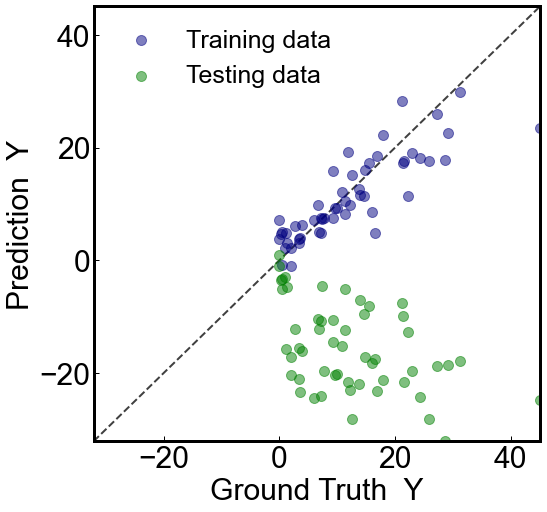

In [55]:
obj_name =  ' Y'
prediction_vs_ground_truth_fig(y_truth_test, y_pred_test, y_truth_test, y_pred_test_all)

# bo迭代预测测试

In [4]:
def find_y_by_x(x_input, X_all, Y_all):  #一通过x找到对应的y的函数
    # 确保 x_input 是一个二维数组
    if len(x_input.shape) == 1:
        x_input = x_input.reshape(1, -1)

    # 初始化一个列表来存储所有结果
    all_results = []

    # 遍历 x_input 中的每个特征向量
    for x in x_input:
        # 使用 NumPy 的函数 argwhere 来查找 x 在 X 中的位置
        indices = np.argwhere(np.all(X_all == x, axis=1))

        # 初始化一个列表来存储匹配的 Y 值
        matching_y_values = []

        # 遍历匹配的位置
        for index in indices:
            match_index = index[0]
            matching_y_values.append(Y_all[match_index])

        all_results.append(matching_y_values)
    
    all_results = np.array(all_results)
    return all_results


In [6]:
# 读取CSV文件中的数据
file_path = 'data/aryl-1.csv'
data = data = pd.read_csv(file_path, encoding='utf-8', header=None)

# 删除第20列到第46列   #去除芳香卤卤化物的描述符
columns_to_drop = data.columns[19:45]  
data = data.drop(columns=columns_to_drop, axis=1)

num_rows, num_columns = data.shape

print(f"行数：{num_rows}")
print(f"列数：{num_columns}")

# 将最后一列作为y，其他列作为x
y_exp = -data.iloc[:, -1].values  # 最后一列 加 负号
x_exp = data.iloc[:, :-1].values  # 前面所有列

X_all, Y_all = [x_exp, y_exp]



行数：264
列数：95


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from scipy.stats import spearmanr

df_reg= pd.DataFrame()

rmse_list = []
mae_list = []
spearman_list = []
rsquared_list = []


for _ in range(1):  # 重复求均值次数
    
    # 进行初始选点
#     np.random.seed(42)  # 设置随机种子以确保结果可重现
    num_samples_to_select = 100
    random_indices = np.random.choice(X_all.shape[0], num_samples_to_select, replace=False)

    #随机取20个点
    X = X_all[random_indices]
    Y = find_y_by_x(X, X_all, Y_all)
    
    
#     # 假设 X_all 的第47行是要添加的样本点
#     new_sample = X_all[46, :]
#     new_sample = np.array(new_sample)
#     # 在 X 中添加新样本点
#     X = np.vstack([X, new_sample])
#     Y = find_y_by_x(X, X_all, Y_all)
    
    #去除存在nan的点
    nan_indices = np.isnan(Y)
    X = X[~nan_indices.flatten()]
    Y = Y[~nan_indices.flatten()]


    # 初始化模型
    input_dim = 94

    ker = GPy.kern.Matern52(input_dim = input_dim, ARD = True)#
    
    ker.lengthscale.constrain_bounded(0.01, 5) #lengthscale决定着点与点之间的相互作用程度
    ker.variance.constrain_bounded(1e-2, 10000.0) #方差
    
    model_gpy = GPRegression(X,Y, ker)
    
    model_gpy.Gaussian_noise.variance =0.25
    model_gpy.Gaussian_noise.variance.fix()

    model_gpy.randomize()
    model_gpy.optimize_restarts(num_restarts=30,verbose =False, messages=False)

    emukit_model = GPyModelWrapper(model_gpy)
    
    
    #进行优化迭代
    maxiter = 100
    simple_regret = []
    y_min = np.nanmin(Y_all)

    for i in range(maxiter):
        emukit_model.set_data(X, Y)

        ei_acquisition = NegativeLowerConfidenceBound(emukit_model)

        ei_plot = ei_acquisition.evaluate(X_all)
        ei_acquisition_nom = (ei_plot - np.min(ei_plot)) / (np.max(ei_plot) - np.min(ei_plot))

        # values, _ = base_model.predict(X)
        # min_value = np.min(values)
        # predictions, _ = base_model.predict(x_plot)
        # improvement = np.maximum(min_value - predictions, 0)
        # improvement_nom = (improvement - np.min(improvement)) / (np.max(improvement) - np.min(improvement))
        # ei_plot = ei_acquisition_nom * w_t + improvement_nom * w_1                   #我理解的 ei+improvement

        # ei_plot = ei_acquisition_nom * w_t + ei_acquisition_1_nom * w_1                #两个ei相加

        
#将已经采样点的获取函数值设为0

        # 遍历 X 中的每一行
        for x_row in X:
            # 找到 x_row 在 X_all 中的位置索引
            indices = np.where(np.all(X_all == x_row, axis=1))[0]

            # 将对应位置上的 ei_plot 元素设置为 0
            ei_acquisition_nom[indices] = 0


        bs = 1
        sort_index = np.argsort(ei_acquisition_nom, axis =0)

        x_new = []
        top = 1 # You should set it according to your confidence in the model (balance of exploitation and exploration)
        for i in sort_index[-top:]:
                x_new.append(X_all[i][0])
                
        x_new=np.array(x_new)

        #对取样点进行检查
        found_duplicate = True
        found_nan_in_y_new = True

        while found_duplicate or found_nan_in_y_new:
            bs_index = [np.random.randint(top) for i in np.arange(bs)]
            new_x = x_new[bs_index]

            # 检查新生成的 new_x 是否在 X 中已存在
            is_duplicate = np.any(np.all(X == new_x, axis=1))

            # 更新 y_new 以匹配新的 x_new
            new_y = find_y_by_x(new_x, X_all, Y_all)

            # 检查新生成的 y_new 是否包含 NaN
            has_nan_in_y_new = np.isnan(new_y).any()

            if not is_duplicate and not has_nan_in_y_new:
                found_duplicate = False
                found_nan_in_y_new = False
                x_new = new_x
                y_new = new_y

        # 在这之后，x_new 中不含与 X 相同的元素，y_new 不含 NaN
        
#计算对于 x new 的预测情况
        
        f_obj =  emukit_model.model.predict
        y_pred, y_uncer = f_obj(x_new)
        y_pred = -y_pred[:,-1]
        y_uncer = np.sqrt(y_uncer[:,-1])
        y_truth = -y_new[:,-1]
        
        # 计算新的指标
        rmse_value_new = np.sqrt(mean_squared_error(y_truth, y_pred))
        mae_value_new = mean_absolute_error(y_truth, y_pred)
        
#         spearman_value_new = spearmanr(y_truth, y_pred)[0]
        
#         rsquared_value_new = r2_score(y_truth, y_pred)

        # 将新指标存储在列表中
        rmse_list.append(rmse_value_new)
        mae_list.append(mae_value_new)
        
#         spearman_list.append(spearman_value_new)
        
#         rsquared_list.append(rsquared_value_new)



        X = np.append(X, x_new, axis=0)
        Y = np.append(Y, y_new, axis=0)

        regret = abs(min(Y) - y_min).item()
        simple_regret.append(regret)
        
    # 将 DataFrame 追加到主 DataFrame 中
    df_reg = pd.concat([df_reg, pd.DataFrame([simple_regret])], ignore_index=True)

column_means_reg = df_reg.mean()
new_row_reg = pd.DataFrame([column_means_reg])
df_reg = pd.concat([df_reg, new_row_reg], ignore_index=True)
    
    


   

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


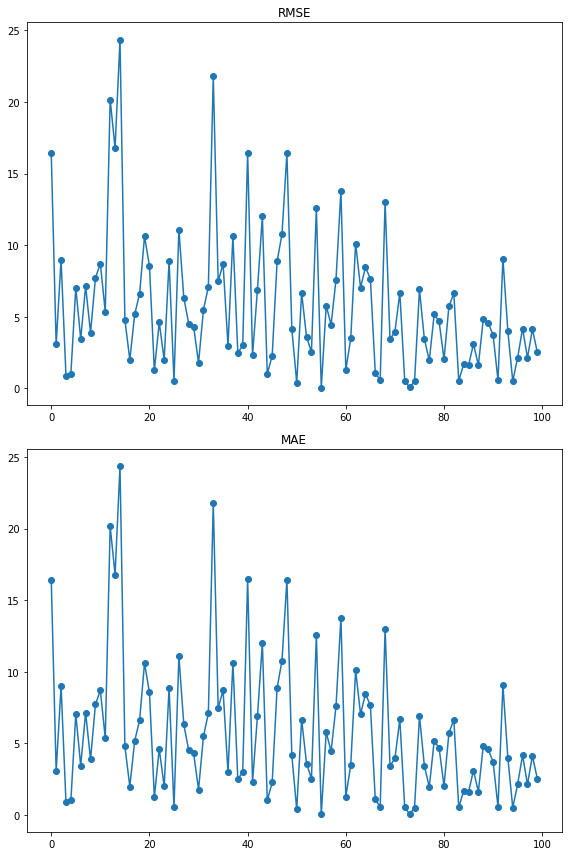

In [27]:
import matplotlib.pyplot as plt

# 创建一个4x1的子图布局
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# 创建自定义横坐标刻度
# x_values = np.arange(len(rmse_list))

# 绘制RMSE折线图
axes[0].plot(x_values, rmse_list, label='RMSE', marker='o')
axes[0].set_title('RMSE')
# axes[0].set_xticks(x_values)

# 绘制MAE折线图
axes[1].plot(x_values, mae_list, label='MAE', marker='o')
axes[1].set_title('MAE')
# axes[1].set_xticks(x_values)

# # 绘制Spearman相关系数折线图
# axes[2].plot(spearman_list, label='Spearman', marker='o')
# axes[2].set_title('Spearman Correlation')

# # 绘制R^2折线图
# axes[3].plot(rsquared_list, label='R^2', marker='o')
# axes[3].set_title('R^2')

# 设置子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()


In [10]:
import numpy as np
from collections import Counter

def find_duplicate_rows(X):
    Z = X
    # 将数组中的每一行表示为元组，并将这些元组存储在列表中
    row_tuples = [tuple(row) for row in Z]

    # 使用Python的collections.Counter来计算元组的出现次数
    row_counts = Counter(row_tuples)

    # 初始化总的重复次数
    total_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 打印重复行的行号（索引）和它们的重复次数，并计算总的重复次数
    for index, row in enumerate(Z):
        row_tuple = tuple(row)
        if row_tuple not in counted_rows:
            count = row_counts[row_tuple]
            if count > 1:
                print(f"行 {index + 1} 重复了 {count} 次")
                total_duplicate_count += count
            counted_rows.add(row_tuple)  # 将该行添加到已计数的行集合中

    # 打印总的重复次数
    print(f"总的重复次数为: {total_duplicate_count}")

    # 初始化总的不同重复行数
    total_unique_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 计算不同的重复行数
    for row_tuple, count in row_counts.items():
        if count > 1:
            total_unique_duplicate_count += 1
            counted_rows.add(row_tuple)

    # 打印总的不同重复行数
    print(f"总的不同重复行数为: {total_unique_duplicate_count}")
    
    
find_duplicate_rows(X)




总的重复次数为: 0
总的不同重复行数为: 0
